In [5]:
flex_title = "Ben_Abbou_Tarik_page_web_102022"
flex_show_source = True
enable_nbextensions=True
show_tracebacks=True

In [329]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from sklearn.model_selection import train_test_split
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array 

import cv2

from keras.layers import Dense, Flatten
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg16 import decode_predictions

 Chargement des données

In [245]:
path_photos = 'C:/Users/benab/OneDrive/Documents/OC/OC_P6/yelp_photos/'
path_photos

'C:/Users/benab/OneDrive/Documents/OC/OC_P6/yelp_photos/'

In [246]:
# Chargement du fichier json
df_photos = pd.read_json(path_photos + "photos.json", lines=True)

In [321]:
df_photos

photo_id             business_id  \
0       zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1       HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2       vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3       pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4       H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   
...                        ...                     ...   
200095  4Zia9NkAfQNjMfcIDhwJ-g  2HxkdqHmbYGj_BH1bLaiSw   
200096  KB96KRZRhRm8hUkI-OpGEA  _gVyuTRb_6HM-SNtqbpevQ   
200097  Klmojvaf2_2dP1XKzTsFmQ  NUyEOjfAl3HvkpzSpdwqeA   
200098  FNEiq7Mogec7t31OaU5juw  hE6YsHHV0fCz_UrGS4o6VA   
200099  NHEtLh7APk7Yssjo0h45VA  VIYvcX9SScnqmoI0so1KZA   

                                                  caption    label  
0       Nice rock artwork everywhere and craploads of ...   inside  
1                                                          outside  
2                                          oyster shooter    drink  
3                                           Shrimp scampi     food  
4                                                             food  
...                                                   ...      ...  
200095                                            #Nektar     food  
200096                                                      inside  
200097                                                        food  
200098                               Drinks by the water!    drink  
200099                                                        food  

[200100 rows x 4 columns]

In [296]:
labels = df_photos['label'].value_counts().index.tolist()
print(labels)

['food', 'inside', 'outside', 'drink', 'menu']


In [250]:
# On récupère 200 photos pour chaque label
list_photos = []
list_labels = []

for label in labels:
    df_sample = df_photos[df_photos['label'] == label].sample(200, random_state=42)
    list_photos.extend(df_sample['photo_id'])
    list_labels.extend(df_sample['label'])

len(list_photos)

1000

# 1. Analyse des photo

## Les photos

Exemple d'image poiur le label : food


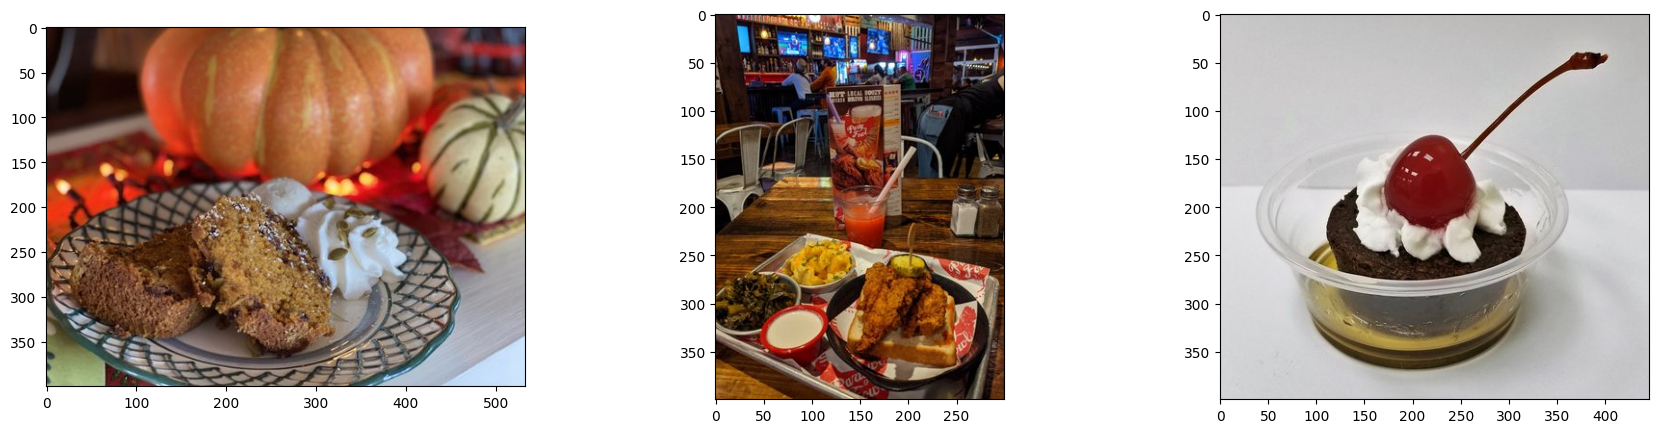

Exemple d'image poiur le label : inside


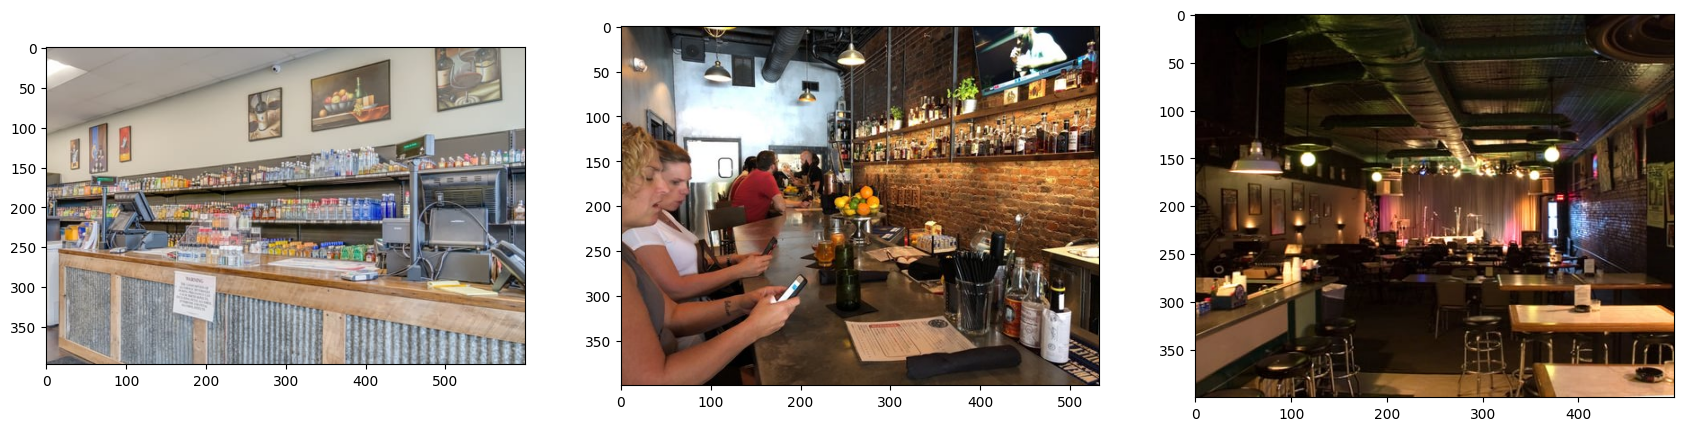

Exemple d'image poiur le label : outside


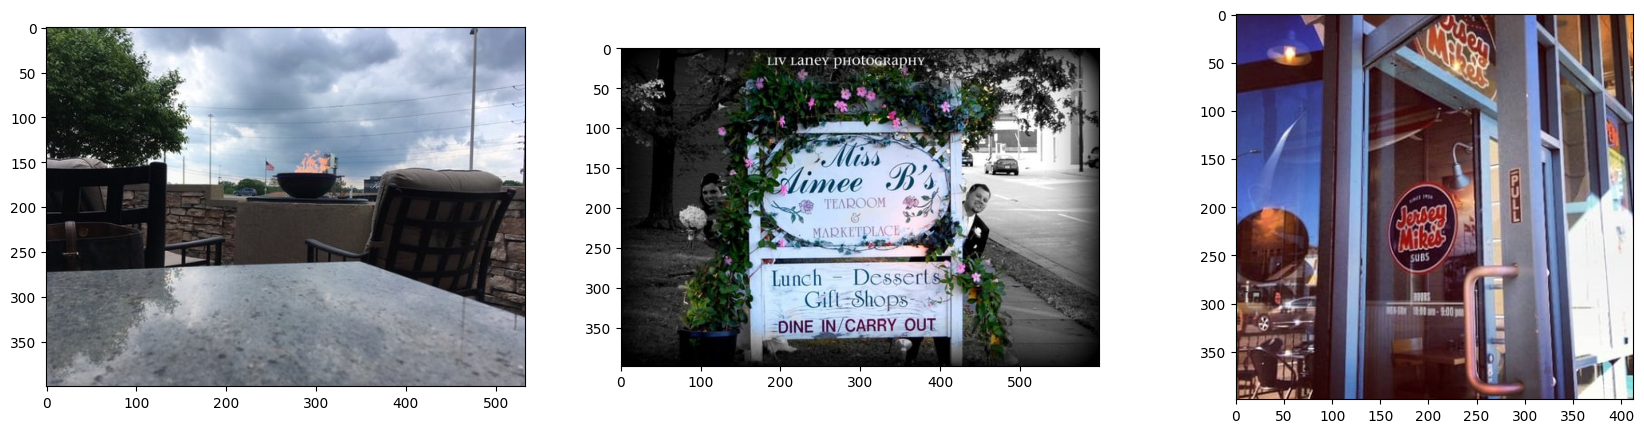

Exemple d'image poiur le label : drink


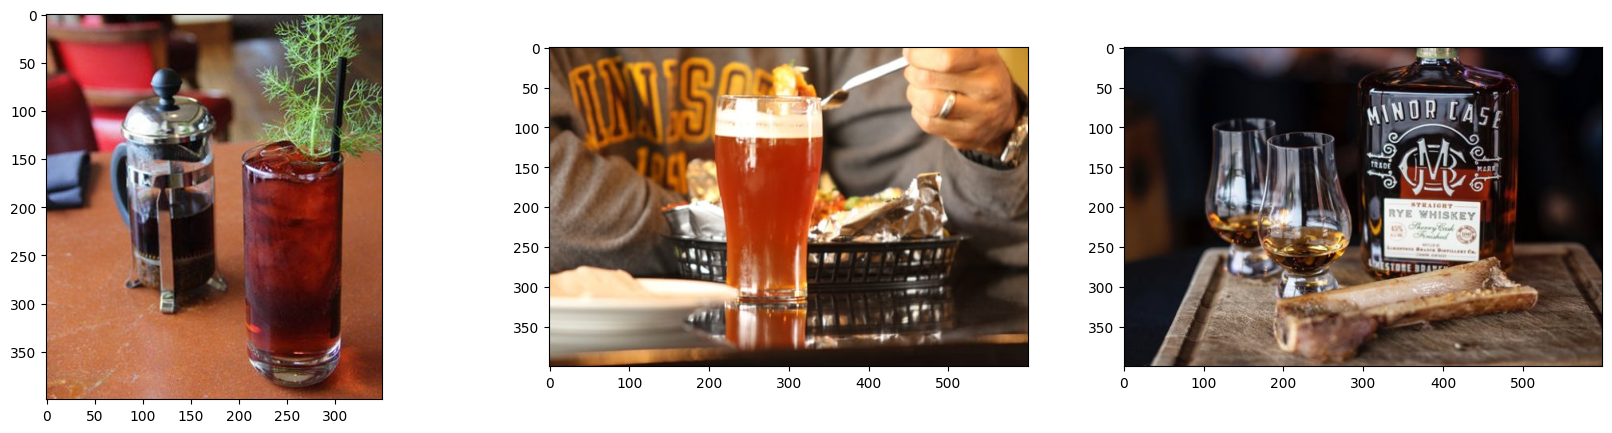

Exemple d'image poiur le label : menu


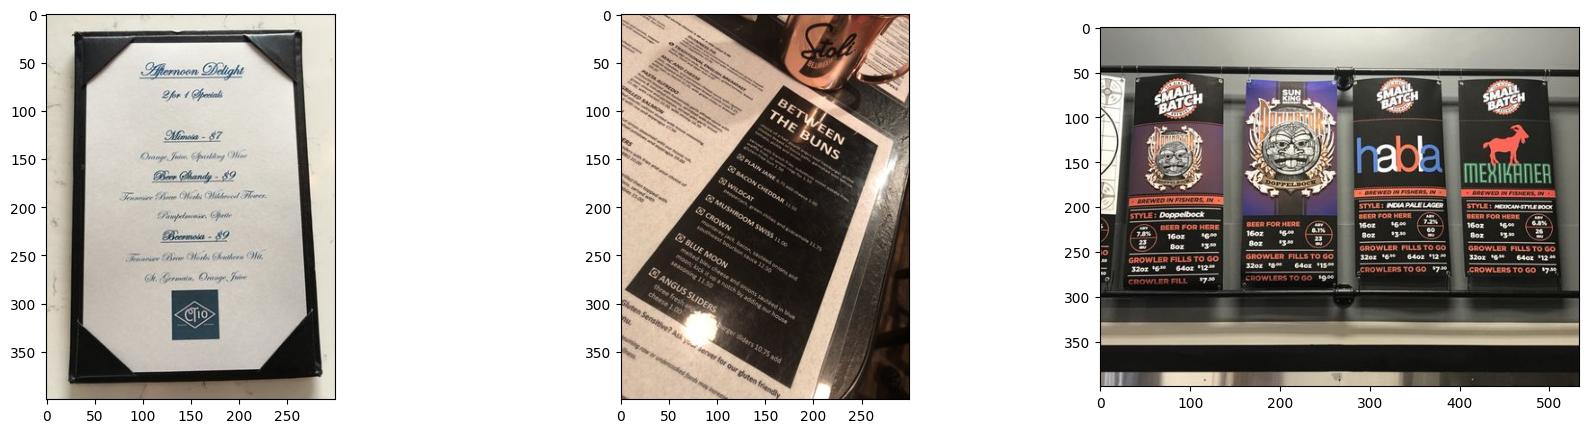

In [251]:
# Affiche 3 images en exemple pour chaque label
for i in range(5):
    print(f"Exemple d'image poiur le label : {labels[i]}")
    plt.subplots(1, 3, figsize=(21,5))
    
    for j in range(3):
        img = Image.open(path_photos + "photos/" + list_photos[i*200+j+3] + ".jpg")
        
        # Afficher l'image
        plt.subplot(1, 3, j+1)
        plt.imshow(img)
    plt.show()

## Les dimensions

In [252]:
# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print(f"Largeur : {w} px, hauteur : {h} px")

# Afficher son mode de quantification
print(f"Format des pixels : {img.mode}")

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print(f"Valeur du pixel situé en (20,100) : {px_value}")

Largeur : 533 px, hauteur : 400 px
Format des pixels : RGB
Valeur du pixel situé en (20,100) : (255, 255, 251)


# 2 .Exemple d'extractions des variables

In [253]:
img = Image.open(path_photos + "photos/" + list_photos[5] + ".jpg")

## PHOTO

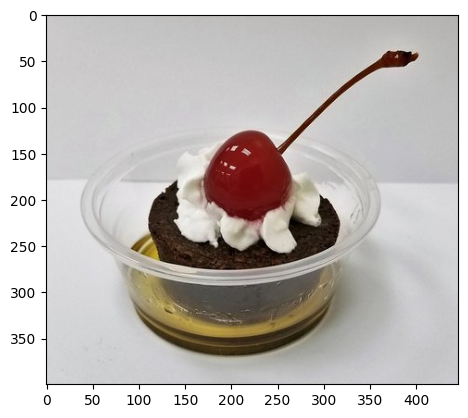

In [254]:
# Afficher l'image
plt.imshow(img)
plt.show()

## Commentaire

La photo couleure choisie pour le traitement.

# 3. Traitement des images

In [255]:
# Affiche l'image et son histogramme de niveau de gris
def show_image_hist(image):
    plt.subplots(1, 2, figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(image.flatten(), bins=range(256))
    plt.show()

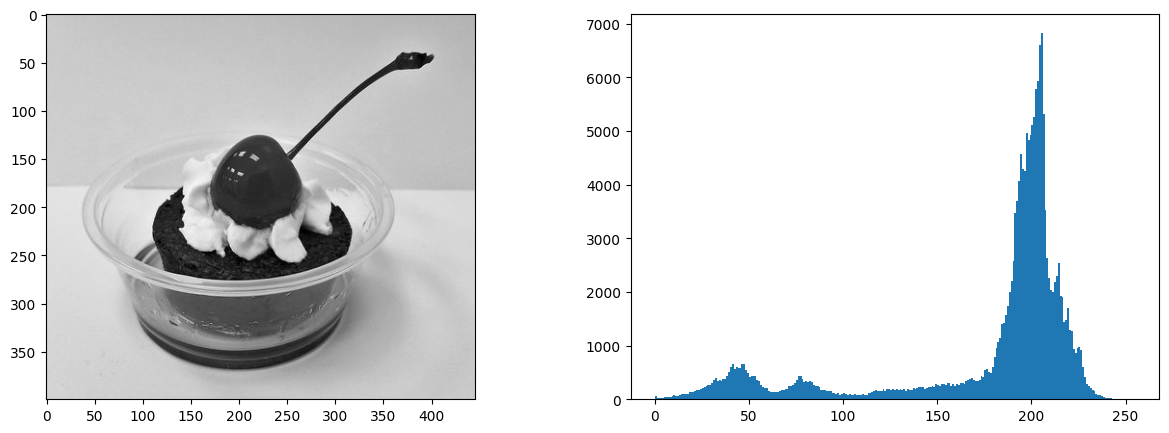

In [256]:
# On convertit notre image en noir et blanc, et on affiche l'histogramme de son niveau de gris
image = cv2.imread(path_photos + "photos/" + list_photos[5] + ".jpg", 0)
show_image_hist(image)

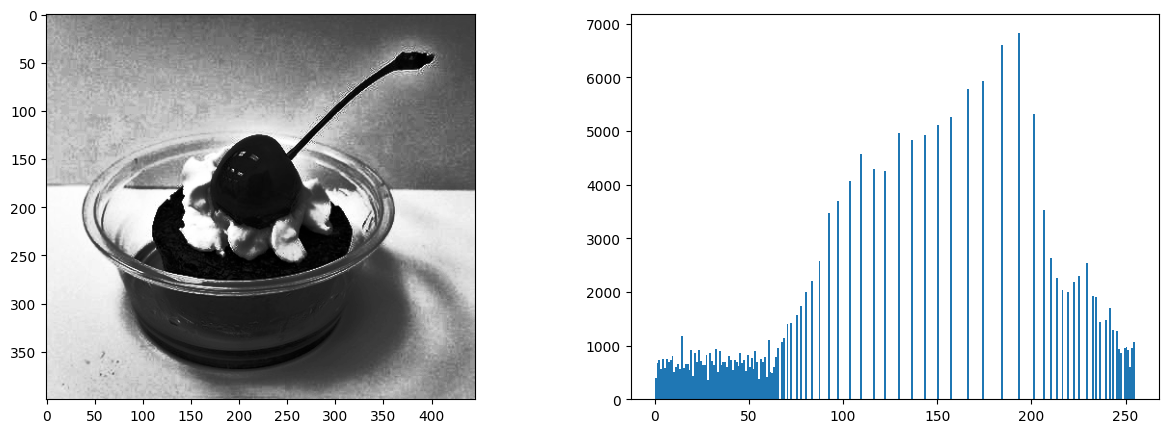

In [257]:
# On corrige la luminosité (ou exposition) et le contraste, en étirant son histogramme puis en l'égalisant
image = cv2.equalizeHist(image)
show_image_hist(image)

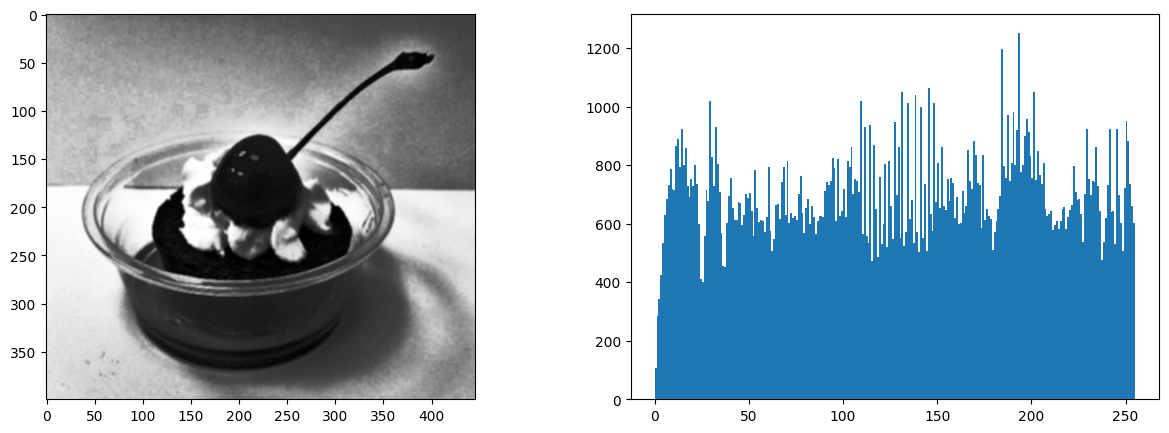

In [258]:
# On élimine le bruit, en contrepartie l'image sera floue puis on filtre l’image de flou
image = cv2.blur(image, (3,3)) 
show_image_hist(image)

# 4. SIFT

## Extraction des features

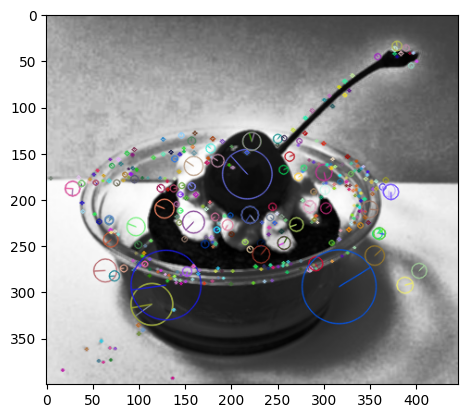

In [259]:
# Exemple d'extraction de features sur cette image avec SIFT
sift = cv2.SIFT_create(nfeatures=400)
kp, des = sift.detectAndCompute(image,None)

img2=cv2.drawKeypoints(image,kp,image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img2)
plt.show()

## Commentaire

La Scale-Invariant Feature Transform  est un algorithme utilisé pour détecter et identifier les éléments similaires entre différentes images numériques.

Il convient de traiter l'image avant d'utiliser SIFT, il s'agit en fait de normaliser son niveau de gris pour corriger la luminosité, le contraste, puis éliminer l'éventuel bruit, ce qui floutera un peu l'image mais ce n'est pas gênant pour l'extraction des features.

SIFT va ensuite calculer des descripteurs de nombre de 400, qui sont des caractéristiques du contenu visuel de l'image, indépendamment du zoom, du cadrage, de l'angle de vision ..

Ainsi, des photographies d'un même objet auront les mème descripteurs SIFT.

Extractions de features sur toutes les images

In [260]:
# Algorithme SIFT calculant 500 descripteurs par image
sift = cv2.SIFT_create(nfeatures=500)

 Traitement des images et extraction des features avec SIFT

In [261]:
def transform_image(img_path, sift):
    img = cv2.imread(img_path, 0)
    img = cv2.equalizeHist(img)
    img = cv2.blur(img, (3,3))
    return sift.detectAndCompute(img,None)

In [262]:
# On traite les images et on calcule les 400 descripteurs pour chacune
# Les descripteurs de chaque image sont ensuite ajoutés dans un tableau
sift_keypoints = []

for photo in list_photos:
    kp, des = transform_image(path_photos + "photos/" + photo + ".jpg", sift)
    sift_keypoints.append(des)

In [263]:
# On aligne les 400 descripteurs par image pour faire une liste unique de descripteur
sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)
print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)


Nombre de descripteurs :  (483227, 128)


KMeans - clustering des descripteurs

On a calculé 400 descripteurs pour chaque image.On va maintenant utiliser l'algorithme kMeans pour clusteriser la totalité des descripteurs.

In [264]:
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

kmeans = cluster.MiniBatchKMeans(n_clusters=k)
kmeans.fit(sift_keypoints_all)

Nombre de clusters estimés :  695
Création de 695 clusters de descripteurs ...


MiniBatchKMeans(n_clusters=695)

In [265]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des==0 : print(f"L'image n°{image_num} n'a pas de descripteurs")
    for i in res:
        
        # pondération par rapport au nombre de descripteur
        hist[i] += 1.0/nb_des 
    return hist

# Création d'une matrice d'histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints) :
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

Chaque histogramme d'une image représente un pourcentage d'appartenance des ses descripteurs à chaque cluster calculé par le kMeans précédent.

 ACP

On va maintenant réduire le nombre de dimensions avec l'ACP, et on garde un nombre de dimensions de façon à avoir une variance expliquée à 99%.

In [266]:
pca = PCA(n_components=0.99, random_state=42)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset après réduction PCA :  (1000, 549)


On passe de 695 à 549 features avec l'ACP.

#  5. TSNE 1

On va maintenant réduire l'espace de dimension avec l'algorithme TSNE, pour obtenir 2 dimensions et pouvoir visualiser sous forme de nuage de points les images et leur label associé.

In [267]:
tsne = TSNE(n_components=2,n_iter=1000,perplexity=30)

X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = list_labels
print(df_tsne.shape)

C:\Users\benab\anaconda3\envs\opencv_env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\benab\anaconda3\envs\opencv_env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 3)


## T-SNE 1

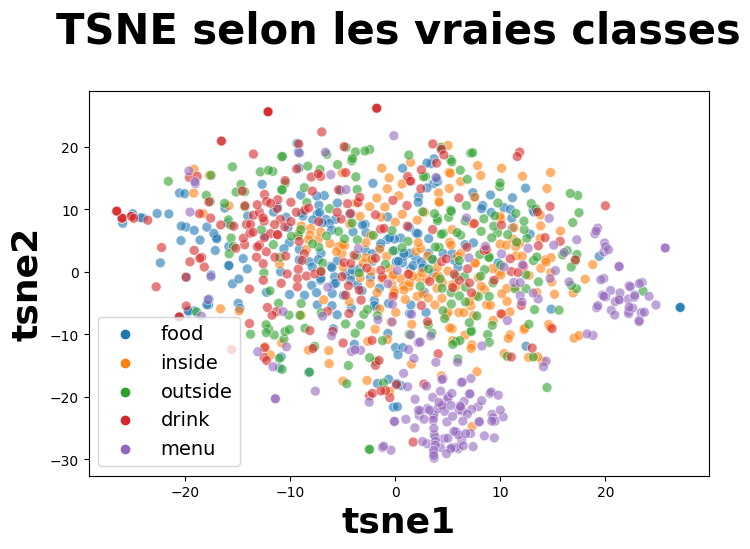

In [268]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

On voit que "menu' se distingue des autres clasess. "food" et "drink" se retrouvent ensemble ainsi que "inside" et "outside".La distinction est tout de même difficile à effectuer.

KMeans - clustering des images en 2 dimensions

On va maintenant clusteriser ces données en 2 dimensions avec l'algorithme kMeans, et comparer le résultat avec les vraies classes.

In [269]:
n_cluster = len(labels)
cls = cluster.KMeans(n_clusters=n_cluster, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1000, 4)


In [270]:
df_tsne["cluster"].value_counts()

1    226
0    216
4    203
2    202
3    153
Name: cluster, dtype: int64

## T-SNE 1

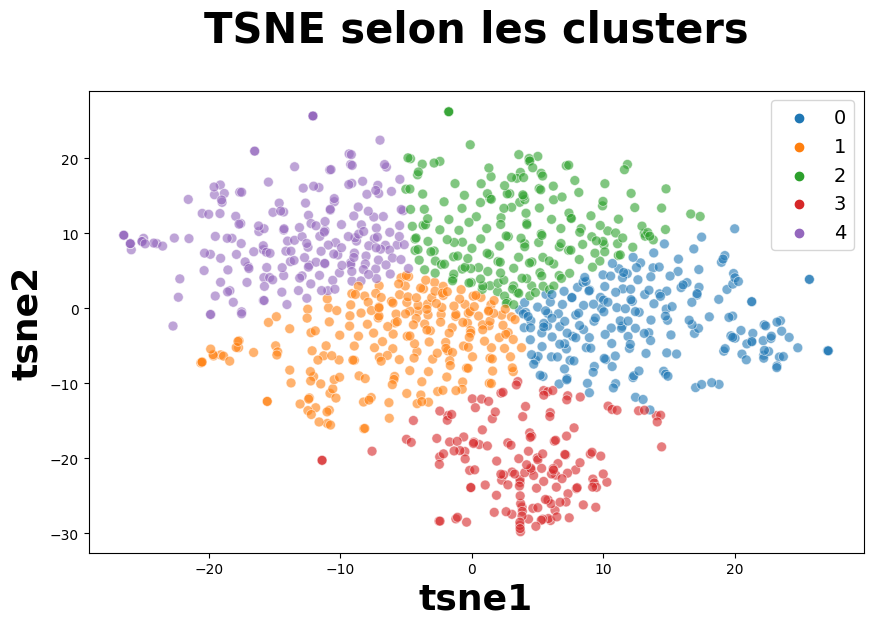

In [271]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=n_cluster), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [272]:
print("ARI : ", metrics.adjusted_rand_score(df_tsne['class'], df_tsne['cluster']))

ARI :  0.09862936779946686


En comparant le clustering sur les données à basse dimensions avec les vraies classes, on obtient un ARI score de 0.108, ce qui est relativement peu.

Le score n'est pas très élevé car les images ont été traitées avant l'utilisation de SIFT, et l'extraction de features ne permet pas d'extraire des bons élements caractéristiques  dans chaque image.

# 6. CNN avec VGG16

On va essayer d'obtenir un score plus important en utilisant cette fois ci un Réseau de neurones convolutif.Les réseaux de neurones convolutifs désignent une sous-catégorie de réseaux de neurones. Les CNN sont spécialement conçus pour traiter des images en entrée.

On va utiliser l'algorithme pré entraîné VGG16, qui permet de classifier une image parmis 1000 classes.Cet algortihme a été entraîné sur un échantillon de millions d'images provenant d'ImageNet.

Voici la représentation 3D de son architecture, on y voit les différentes couches.

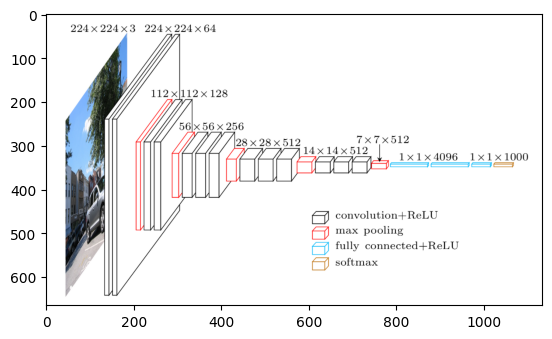

In [273]:
# Read Images 
img = mpimg.imread('vgg16.png') 

# Output Images 
plt.imshow(img)

In [274]:
model = VGG16()

# La taille de l’image d’entrée par défaut de VGG-16 est de 224×224. On redimensionne donc notre image.
img = load_img(path_photos + "photos/" + df_photos.iloc[6]['photo_id'] + ".jpg", target_size=(224, 224))

# On convertit notre image en matrice de pixels.
test_img = img_to_array(img)

# La dimension de l’image d’entrée par défaut de VGG16 est (None,224,224,3), on ajoute donc une autre dimension a notre matrice.
test_img = test_img.reshape((1, test_img.shape[0], test_img.shape[1], test_img.shape[2]))

# Traiter les pixels de l’image de la même manière que les données d’entraînement d’ImageNet ont été préparées.
test_img = preprocess_input(test_img)

prediction = model.predict(test_img)

1/1 [==============================] - 1s 564ms/step


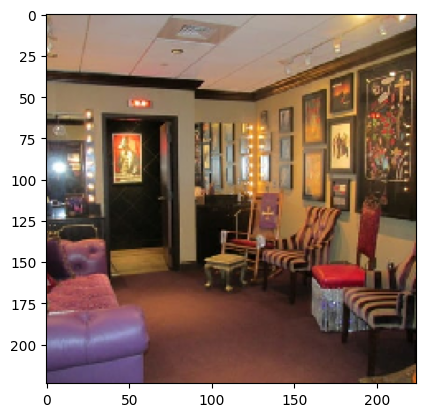

In [275]:
# Afficher l'image
plt.imshow(img)
plt.show()

In [295]:
labels_ = decode_predictions(prediction)
print('%s (%.2f%%)' % (labels_[0][0][1], labels_[0][0][2]*100))
print('%s (%.2f%%)' % (labels_[0][1][1], labels_[0][1][2]*100))
print('%s (%.2f%%)' % (labels_[0][2][1], labels_[0][2][2]*100))

home_theater (52.70%)
cinema (15.92%)
restaurant (12.04%)


La classification est précise, et fournis un pourcentage de probabilité d'appartenance à plusieurs classes. Ici on a restaurant qui ressort avec 12,04%.

Extraction de features

In [277]:
# Modèle VGG16 sans la couche top
model = VGG16(weights="imagenet", include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [278]:
# Méthode pour traiter chaque image avant de la passer en entrée de l'algorithme
def preprocess_image(path):
    img = img_to_array(load_img(path_photos + "photos/" + path + ".jpg", target_size=(224, 224)))
    return preprocess_input(np.expand_dims(img, axis=0))

In [279]:
# On récupère dans une liste les features de chaque image calculée par notre modèle
vgg16_feature_list = []

for photo in list_photos:
    vgg16_feature = model.predict(preprocess_image(photo))
    vgg16_feature_np = np.array(vgg16_feature)
    vgg16_feature_list.append(vgg16_feature_np.flatten())

vgg16_feature_list_np = np.array(vgg16_feature_list)

1/1 [==============================] - 1s 594ms/step


In [280]:
vgg16_feature_list_np.shape

(1000, 25088)

ACP

On va maintenant réduire le nombre de dimensions avec l'ACP, et on garde un nombre de dimensions de façon à avoir une variance expliquée à 99%.

In [281]:
pca_vgg = PCA(n_components=0.99, random_state=42)
feat_pca_vgg = pca_vgg.fit_transform(vgg16_feature_list_np)
print("Dimensions dataset après réduction PCA : ", feat_pca_vgg.shape)

Dimensions dataset après réduction PCA :  (1000, 928)


On passe de 25088 à 928 features avec l'ACP.

# 7. TSNE 2 

On va maintenant réduire l'espace de dimension avec TSNE, pour obtenir 2 dimensions et pouvoir visualiser sous forme de nuage de points les images et leur label associé.

In [287]:
tsne_vgg = TSNE(n_components=2,n_iter=1000,perplexity=30)

X_tsne_vgg = tsne_vgg.fit_transform(feat_pca_vgg)

df_tsne_vgg = pd.DataFrame(X_tsne_vgg, columns=['tsne1', 'tsne2'])
df_tsne_vgg["class"] = list_labels
print(df_tsne_vgg.shape)

C:\Users\benab\anaconda3\envs\opencv_env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\benab\anaconda3\envs\opencv_env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 3)


## T-SNE 2

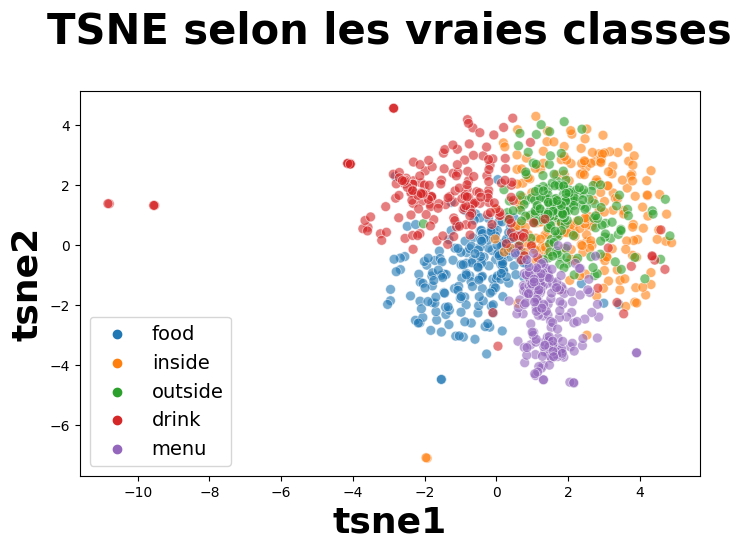

In [302]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_vgg, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

La classification est mieux réalisée qu'avec le SIFT. On distingue bien les 5 classes.

KMeans

On va maintenant clusteriser ces données en 2 dimensions avec l'algorithme kMeans, et comparer le résultat avec les vraies classes.

In [297]:
from sklearn.cluster import KMeans

n_cluster = len(labels)
cls_vgg = cluster.KMeans(n_clusters = n_cluster, random_state=42)
cls_vgg.fit(X_tsne_vgg)

KMeans(n_clusters=5, random_state=42)

In [299]:
df_tsne_vgg["cluster"] = cls_vgg.labels_
print(df_tsne_vgg.shape)

df_tsne_vgg["cluster"].value_counts()

(1000, 4)


2    256
0    244
1    191
4    173
3    136
Name: cluster, dtype: int64

## T-SNE 2

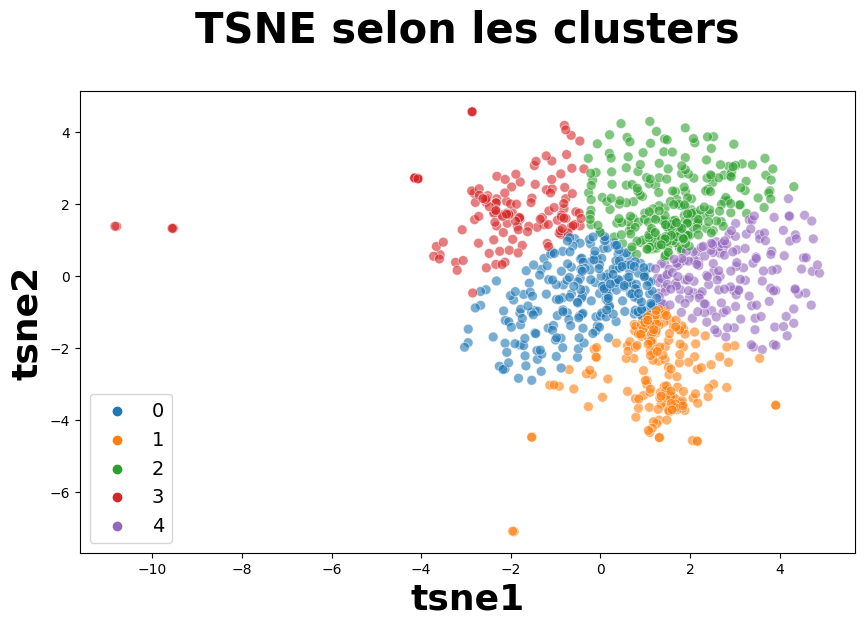

In [301]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=n_cluster), s=50, alpha=0.6,
    data=df_tsne_vgg,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [303]:
print("ARI : ", metrics.adjusted_rand_score(df_tsne_vgg['class'], df_tsne_vgg['cluster']))

ARI :  0.4543200857562155


On obtient un bien meilleur ARI score que précedemment. Il est ici de 0.45

# 8. Transfer Learning

L'apprentissage par transfert, on va ré-entraîner une partie du réseau sur les nouvelles classes (nos 5 classes), afin d'y faire par la suite une classification sur ces 5 classes plutôt que sur les 1000 classes du modèle pré-entraîné. On va donc récupérer certaines couches du VGG16 que l'on va ré-entraîner.

In [304]:
# On récupère le modèle VGG16
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3), classes=5)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [305]:
# On enlève les couches du modèle pré-entraîné
for layer in vgg.layers:
    layer.trainable = False

In [319]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 

In [331]:
### Column 1 - Row 1
x = vgg.output
x = Flatten()(x)

# Ajouter la nouvelle couche fully-connected pour la classification à 5 classes
predictions = Dense(5, activation="softmax")(x)

# Définir le nouveau modèle
model = Model(inputs=vgg.input, outputs=predictions)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [307]:
# Compiler le modèle
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [308]:
# Méthode pour traiter chaque image avant de la passer en entrée de l'algorithme
def preprocess_img(path):
    img = img_to_array(load_img(path_photos + "photos/" + path + ".jpg", target_size=(224, 224)))
    return preprocess_input(img)

In [309]:
def preprocess_label(label):
    dic = {
        "food":0,
        "inside":1,
        "outside":2,
        "drink":3,
        "menu":4
    }
    return dic[label]

In [310]:
X = np.asarray([preprocess_img(path) for path in list_photos])
y = np.asarray([preprocess_label(label) for label in list_labels])

In [311]:
# On sépare nos données en jeu de test et en jeu d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [312]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = model.fit(X_train, y_train, epochs=8, batch_size=256)

Epoch 1/8
4/4 [==============================] - 300s 68s/step - loss: 14.0271 - accuracy: 0.4538
Epoch 2/8
4/4 [==============================] - 292s 66s/step - loss: 1.7014 - accuracy: 0.9038
Epoch 3/8
4/4 [==============================] - 298s 69s/step - loss: 1.0591 - accuracy: 0.9450
Epoch 4/8
4/4 [==============================] - 295s 67s/step - loss: 0.2268 - accuracy: 0.9875
Epoch 5/8
4/4 [==============================] - 13344s 4416s/step - loss: 0.0037 - accuracy: 0.9987
Epoch 6/8
4/4 [==============================] - 267s 61s/step - loss: 0.0035 - accuracy: 0.9987
Epoch 7/8
4/4 [==============================] - 287s 67s/step - loss: 0.0037 - accuracy: 0.9975
Epoch 8/8
4/4 [==============================] - 589s 164s/step - loss: 3.2507e-05 - accuracy: 1.0000


In [314]:
# On évalue accuracy et loss sur le jeu de test
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

7/7 [==============================] - 67s 9s/step - loss: 4.7117 - accuracy: 0.8700
Test loss: 4.711728096008301
Test accuracy: 0.8700000047683716


On a une précision de 88% ce qui est mieux que les méthodes précédentes.

In [315]:
y_predicted = model.predict(X_test)

7/7 [==============================] - 69s 10s/step


In [316]:
predicted_classes = np.argmax(y_predicted, axis=1)

true_classes = np.argmax(y_test,axis=1)

## Column 2 

### confusion_matrix

In [317]:
cm = confusion_matrix(true_classes,predicted_classes)

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       0.89      0.81      0.85        48
           2       0.64      0.92      0.76        37
           3       1.00      0.89      0.94        38
           4       1.00      0.77      0.87        44

    accuracy                           0.87       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.90      0.87      0.87       200



###  DataFrame

In [318]:
pd.DataFrame(cm,columns=labels,index=labels)

food  inside  outside  drink  menu
food       33       0        0      0     0
inside      1      39        8      0     0
outside     0       3       34      0     0
drink       1       2        1     34     0
menu        0       0       10      0    34

### Conclusion

En utilisant l'aglorithme VGG16 ré-entraîné sur nos classes, on obient une bonne précision de 89%.

La matrice de confusion nous permet d'observer comment chaque image est prédite en fonction de sa vraie classe.